 # Running Log Analytics

In [22]:
import os.path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Import running log data using Google Workspace API

### Define User Inputs

In [62]:
SCOPES = ["https://www.googleapis.com/auth/spreadsheets.readonly"]
SPREADSHEET_ID = "1VdRxTTKiQk_9wtxOaegy8d-PMaSG-ijkFDCBGHjY_nw"
SHEET_ID = "1403524267"
RANGE_NAME = "ACTIVITY LOG!A:AH"

### Set Credentials

In [63]:
creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json", SCOPES)
    # If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
      creds.refresh(Request())
    else:
      flow = InstalledAppFlow.from_client_secrets_file(
          "credentials.json", SCOPES
      )
      creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open("token.json", "w") as token:
      token.write(creds.to_json())


### Import Data from Sheets

In [144]:
try:
    service = build("sheets", "v4", credentials=creds)
    
    # Call sheets API
    sheet = service.spreadsheets()
    result = (
        sheet.values()
        .get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME)
        .execute()
        )
    
    values = result.get("values", [])

    
    if not values:
        print("No data found.")
    
    # Clean data and set data types
    for i in range(len(values)):
        # Ignore empty rows.
        if values[i][5] and i > 0:
            # Define the rows from activity log
            values[i][0] = int(values[i][0]) # Day number
            values[i][1] = bool(values[i][1] == 'TRUE') # EOW
            values[i][2] = bool(values[i][2] == 'TRUE') # EOM
            values[i][3] = bool(values[i][3] == 'TRUE') # EOY
            values[i][4] = str(values[i][4]) # Day
            values[i][5] = datetime.strptime(str(values[i][5]), '%m/%d/%Y').date() # Date
            values[i][6] = float(values[i][6]) # Distance
            try:
                values[i][7] = datetime.strptime(str(values[i][7]), '%H:%M:%S').time() # Duration
            except ValueError:
                values[i][7] = None
            try:
                values[i][8] = datetime.strptime(str(values[i][8]), '%H:%M:%S').time() # Pace
            except:
                values[i][8] = None
            values[i][9] = str(values[i][9]) # Activity Type
            try:
                values[i][10] = int(values[i][10]) # Elevation Gain
            except ValueError:
                values[i][10] = None
            try:
                values[i][11] = int(values[i][11]) # Heart Rate
            except ValueError:
                values[i][11] = None
            try:    
                values[i][12] = int(values[i][12]) # Cadence
            except ValueError:
                values[i][12] = None
            values[i][13] = str(values[i][13]) # 
            values[i][14] = str(values[i][14]) # 
            values[i][15] = bool(values[i][15] == 'TRUE') # Drills
            values[i][16] = bool(values[i][16] == 'TRUE') # Strides
            values[i][17] = bool(values[i][17] == 'TRUE') # Strength
            try:
                values[i][18] = float(values[i][18]) # Sleep Hours
            except ValueError:
                values[i][18] = None
            values[i][19] = str(values[i][19]) # Sleep Quality
            values[i][20] = str(values[i][20]) # Energy
            values[i][21] = bool(values[i][21] == 'TRUE') # Nap
            values[i][22] = float(values[i][22]) # WTD Easy
            values[i][23] = float(values[i][23]) # WTD Hard
            values[i][24] = float(values[i][24]) # WTD Long
            values[i][25] = float(values[i][25]) # WTD Bike
            values[i][26] = float(values[i][26]) # WTD Other
            values[i][27] = str(values[i][27]) # WTD XT Time
            values[i][28] = str(values[i][28]) # WTD Run Time
            values[i][29] = float(values[i][29]) # WTD
            values[i][30] = float(values[i][30]) # MTD
            values[i][31] = float(values[i][31]) # YTD
            values[i][32] = float(values[i][32]) # Total Distance
            try:
                values[i][33] = str(values[i][33]) # Equipment
            except IndexError:
                values[i].append(None) 
    
except HttpError as err:
    print(err)
    
run_df = pd.DataFrame(data=values[1:],columns=values[0])
run_df = run_df[run_df['Date'] != ''] # Remove empty rows from data frame.

# print(run_df['Energy'])

## Running Analytics

### Linear Regression

#### Future Steps:
- Adding effort and energy levels might be interesting and are tracked on the Google Sheet
- Import time, elevation, and location data from activities using Garmin or Strava API
- Import weather data from OpenWeatherMap API
- How to incorporate changes in fitness?
- What if non-linear?

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.103
Date:                Wed, 03 Jan 2024   Prob (F-statistic):              0.357
Time:                        20:01:39   Log-Likelihood:                -1960.2
No. Observations:                 419   AIC:                             3944.
Df Residuals:                     407   BIC:                             3993.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.3774    121.457      0.579      0.563    -168.384     309.139
x1             2.2440      4.657      0.482      0.630      -6.911      11.399
x2            -0.2293      0.652     -0.351      0.725      -1.512       1.053
x3            -3.0753      3.846     -0.800      0.424     -10.637       4.486
x4             0.0011      0.006      0.183      0.855      -0.011       0.013
x5             0.6823      0.657      1.038      0.300      -0.610       1.974
x6            -0.6186      1.531     -0.404      0.686      -3.628       2.390
x7            -2.9010      3.392     -0.855      0.393      -9.570       3.768
x8           -18.7556     27.973     -0.670      0.503     -73.746      36.235
x9           -17.3224     28.382     -0.610      0.542     -73.116      38.471
x10           -0.3745      2.049     -0.183      0.855      -4.403       3.654
x11            0.4503      5.306      0.085      0.932      -9.980      10.881
==============================================================================
Omnibus:                      887.584   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1480818.733
Skew:                          15.280   Prob(JB):                         0.00
Kurtosis:                     292.631   Cond. No.                     3.78e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

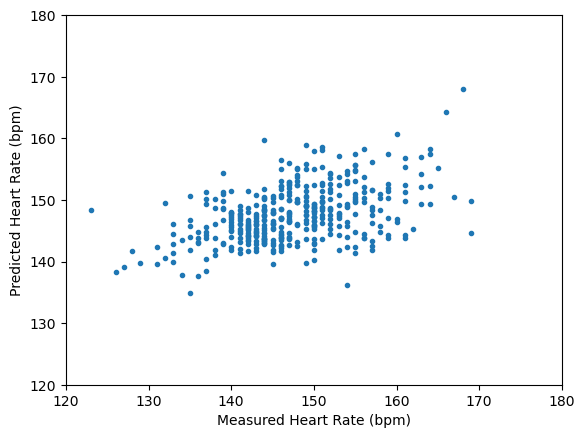

In [151]:
easy_df = run_df
type_dummy_df = pd.get_dummies(easy_df['Type'], prefix='Type')

energy_order = ['Barely functioning', 'Low', 'Normal', 'High']
feel_order = ['Awful', 'Bad', 'Normal', 'Good', 'Great']
effort_order = ['Easy', 'Moderate', 'Hard', 'Max Effort']

easy_df['energy_encoded'] = easy_df['Energy'].astype('category').cat.set_categories(energy_order).cat.codes.replace(-1, None)
easy_df['feel_encoded'] = easy_df['Feel'].astype('category').cat.set_categories(feel_order).cat.codes.replace(-1, None)
easy_df['effort_encoded'] = easy_df['Effort'].astype('category').cat.set_categories(effort_order).cat.codes.replace(-1, None)

easy_df = pd.concat([easy_df, type_dummy_df], axis=1)

X = easy_df[['Distance (mi.)', 'Duration (hh:mm:ss)', 'Pace (min/mile)', 'Climb (ft.)', 'Cadence', 'Sleep (hours)', 'energy_encoded', 'Type_Long Run', 'Type_Easy', 'feel_encoded', 'effort_encoded', 'HR (bpm)']]
X = X.dropna()
X['Duration (hh:mm:ss)'] = X['Duration (hh:mm:ss)'].apply(lambda x: x.hour * 60 + x.minute)
X['Pace (min/mile)'] = X['Pace (min/mile)'].apply(lambda x: x.hour * 60 + x.minute)
y = X['HR (bpm)']
X = X.drop('HR (bpm)', axis=1)

lin_reg = LinearRegression()

lin_reg.fit(X, y)
y_predict = lin_reg.predict(X)

lin_reg_fig, lin_reg_ax = plt.subplots(1)
lin_reg_ax.plot(y.values, y_predict, linewidth=0, marker='.')
lin_reg_ax.set_xlim(120, 180)
lin_reg_ax.set_ylim(120, 180)
lin_reg_ax.set_ylabel('Predicted Heart Rate (bpm)')
lin_reg_ax.set_xlabel('Measured Heart Rate (bpm)')

rmse = math.sqrt(mean_squared_error(y, y_predict))
r_squared = r2_score(y, y_predict)

X = np.array(X, dtype=float)
y = np.array(y, dtype=float)

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

model.summary()

### Heart Rate Analytics

Text(0, 0.5, 'Heart Rate (bpm)')

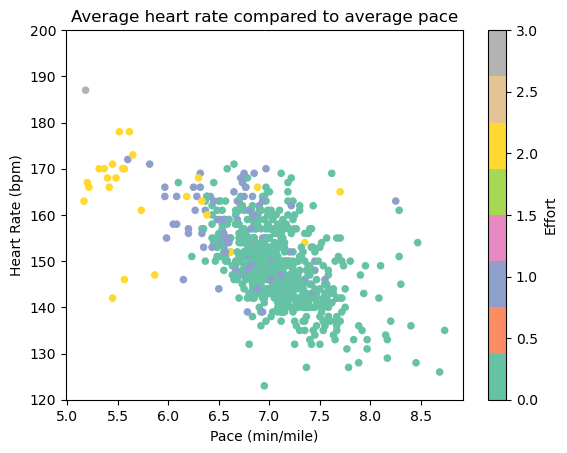

In [142]:
easy_df = run_df

colormap = plt.get_cmap('Set2')
easy_df['pace_float'] = easy_df['Pace (min/mile)'].apply(lambda x: x.minute+x.second/60)

hr_ax = easy_df.plot(x='pace_float', y='HR (bpm)', kind='scatter', c=easy_df['effort_encoded'], cmap=colormap)
plt.colorbar(hr_ax.get_children()[0], label='Effort')
hr_ax.set_ylim(120, 200)
hr_ax.set_title('Average heart rate compared to average pace')
hr_ax.set_xlabel('Pace (min/mile)')
hr_ax.set_ylabel('Heart Rate (bpm)')